## Description


In today's class, we will work with diagnostics of linear model, i.e., we will check if the assumptions of the linear regression are satisfied. We will also discuss the individual and joint significance of the parameters in our model and look for any outlying observations.

The assumptions we will check can be summarized as the LINE rule:    

- **L**inear trend,
- **I**ndependent residuals (lack of autocorrelation),
- **N**ormally distributed residuals,
- **E**qual variance of residuals for all values of independent variables (homoskesasticity).

We will check them visually by creating and analyzing the following diagnostic plots:   

- The residual value vs the fitted value
- The root square of the absolute value of standardized residuals vs the fitted value,
- The histogram of residuals.

The first plot is used to check if the relationship between the response (the dependent variable) and the predictors (the independent variables) is linear, and for a very rough check if the residuals are uncorrelated. We expect values distributed symmetrically across the line $y=0$. However, as stated in the lecture, this plot may be misleading if non-spherical random disturbance occurs. That is why, we encourage to perform Ramsey RESET test.  

The second plot is used to check homoskedasticity (equality for all values of the independent variables) of variance. We expect values distributed symmetrically across a straight horizontal line.    

The histogram is used to visualize the distribution of residuals.  
You can also use a qq-plot in this case if you know how to create and interpret it.

Finally, inspect either the influence plot or the leverage-resid2 plot,  [implemented in `statsmodels`](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html).  
Both plots used to detect outliers that highly influence the model parameters.

In [1]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1GW1pjKOCoKOlC4Jqbqql_ghYD_n0iC6O
!gdown https://drive.google.com/uc?id=1FInZ2jrlZGNColU4sHF9JKGHP39fTVut
!gdown https://drive.google.com/uc?id=1n1qS6dcVVKcVJOuUIIm0VTz6cSyrtzDH

Downloading...
From: https://drive.google.com/uc?id=1GW1pjKOCoKOlC4Jqbqql_ghYD_n0iC6O
To: /home/kinzoku99/Pulpit/SML/Labs/BDL municipality incomes 2015-2020.csv
100%|████████████████████████████████████████| 228k/228k [00:00<00:00, 3.47MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FInZ2jrlZGNColU4sHF9JKGHP39fTVut
To: /home/kinzoku99/Pulpit/SML/Labs/BDL municipality area km2 2015-2020.csv
100%|████████████████████████████████████████| 180k/180k [00:00<00:00, 2.35MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n1qS6dcVVKcVJOuUIIm0VTz6cSyrtzDH
To: /home/kinzoku99/Pulpit/SML/Labs/BDL municipality population 2015-2020.csv
100%|████████████████████████████████████████| 222k/222k [00:00<00:00, 3.08MB/s]


## Data & library imports

In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
import statsmodels.api as sm
from scipy.linalg import svd

In [3]:
income = pd.read_csv('BDL municipality incomes 2015-2020.csv', sep=';', dtype={'Code': 'str'})
population = pd.read_csv('BDL municipality population 2015-2020.csv', sep='\t', dtype={'Code': 'str'})
area = pd.read_csv('BDL municipality area km2 2015-2020.csv', sep='\t', dtype={'Code': 'str'})

In [4]:
voivodeship_names = {
    '02': 'Dolnośląskie',
    '04': 'Kujawsko-pomorskie',
    '06': 'Lubelskie',
    '08': 'Lubuskie',
    '10': 'Łódzkie',
    '12': 'Małopolskie',
    '14': 'Mazowieckie',
    '16': 'Opolskie',
    '18': 'Podkarpackie',
    '20': 'Podlaskie',
    '22': 'Pomorskie',
    '24': 'Śląskie',
    '26': 'Świętokrzyskie',
    '28': 'Warmińsko-mazurskie',
    '30': 'Wielkopolskie',
    '32': 'Zachodniopomorskie'
}

In [5]:
code_list = [s[:2] for s in income["Code"]]
name_list = [voivodeship_names[code] for code in code_list]
income['Voivodeship'] = name_list

## Diagnostics when assumptions are not satisfied

**Exercise 2.**  

In this exercise, we will predict the income of a municipality in 2020 based on its population and voivodeship.

Create a data frame with the territorial code, income, population and voivodeships of municipalities in 2020 by using `pd.merge` to perform a join with the `Code` variable as the key. Remove rows with missing values.   
Use the `pd.get_dummies()` function to encode the voivodeship for each municipality with dummy variables.   

Estimate the model and inspect its summary.  
Are the variables jointly significant according to the F-test?  
Are all individual variables significant according to the t-test?
What are the interpretations of the parameters?  
Can you use a model with intercept in this exercise? Why / why not? If yes, what is its interpretation?

Conduct the diagnostics of the model. Decide which assumptions are satisfied to an appropriate degree.  
If you detect an outlying observation, remove it from the data set, run the calculations and diagnostics again and check if it improves the model fit.  

If you detect heteroskedasticity (non-constant variance of residuals), transforming the data may help.  
You may transform both the dependent and independent variable.  
Transforming the latter changes the functional relationship between the variables (i.e. whether they are linearly related), while transforming the former changes both the relationship and the structure of the residual variance.  

Estimate the average error in PLN that you would make if you used your model to predict the income of a municipality from its population.

In [6]:
data = pd.merge(income[['Code', '2020', 'Voivodeship']], population[['Code', '2020']], on='Code', suffixes=['income', 'population'])
data.dropna(inplace=True)
data = pd.get_dummies(data, columns=['Voivodeship'])
Y = data['2020income']
X = data.iloc[:, 2:]
X

,2020population,Voivodeship_Dolnośląskie,Voivodeship_Kujawsko-pomorskie,Voivodeship_Lubelskie,Voivodeship_Lubuskie,Voivodeship_Mazowieckie,Voivodeship_Małopolskie,Voivodeship_Opolskie,Voivodeship_Podkarpackie,Voivodeship_Podlaskie,Voivodeship_Pomorskie,Voivodeship_Warmińsko-mazurskie,Voivodeship_Wielkopolskie,Voivodeship_Zachodniopomorskie,Voivodeship_Łódzkie,Voivodeship_Śląskie,Voivodeship_Świętokrzyskie
0,38486.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14863.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5317.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,15229.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7288.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2504,7885.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2505,6856.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2506,106235.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2507,398255.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [7]:
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             2020income   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     2381.
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:55:28   Log-Likelihood:                -48400.
No. Observations:                2477   AIC:                         9.683e+04
Df Residuals:                    2460   BIC:                         9.693e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
2020popula

In [8]:
# Results of RESET test
print(sm.stats.diagnostic.linear_reset(results, power=3, test_type='fitted'))
# p-value = 0.0 -- we reject the null hypothesis -- the functional form is incorrect

<Wald test (chi2): statistic=10135.71229607439, p-value=0.0, df_denom=1>


/home/kinzoku99/.local/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [9]:
## Get the fitted values:
fitted_values_summary = results.get_prediction().summary_frame()
fitted_values = fitted_values_summary['mean']
## Compute the residuals:
residuals = Y - fitted_values

In [10]:
## The average prediction error can be estimated by RMSE
## (it's an estimation on training data, so it's biased)
print('RMSE of the model:', np.sqrt(np.mean(residuals**2)))

RMSE of the model: 74088553.12617037


/tmp/ipykernel_7646/2582912159.py:11: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



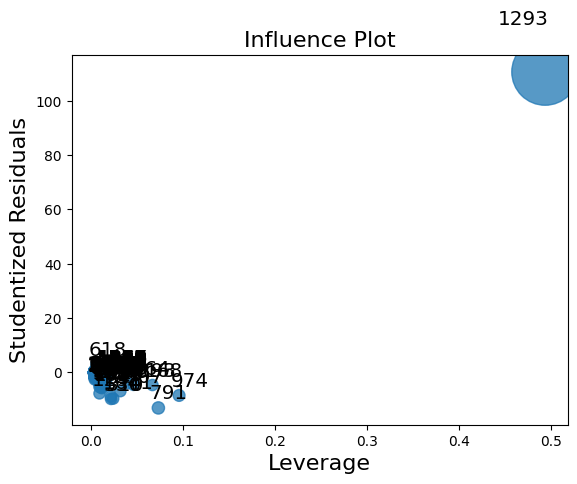

In [11]:
## Standardize the residuals & compute the square root:
residuals_standardized = (residuals - residuals.mean())/residuals.std()
residuals_sqroot = np.sqrt(np.abs(residuals_standardized))
## Diagnostic plots:
px.scatter(x=fitted_values, y=residuals,
           title='Residual vs fitted value').add_scatter(x=[min(fitted_values),
                                                            max(fitted_values)],
                                                         y=[0,0]).show()
px.scatter(x=fitted_values, y=residuals_sqroot, title='Scale vs location').show()
px.histogram(x=residuals, title='Residuals').show()
sm.graphics.influence_plot(results, criterion="cooks").show()

Fit a model with intercept (observe P>|t| in the summary and compare with the results for the case without intercept):

In [12]:
## Get the data and the dummy variables:
data = pd.merge(income[['Code', '2020', 'Voivodeship']], population[['Code', '2020']], on='Code', suffixes=['income', 'population'])
data.dropna(inplace=True)
data = pd.get_dummies(data, columns=['Voivodeship'])
Y = data['2020income']

## Fit a model with intercept by dropping a reference category (R-style):
X = np.hstack(([[1]]*data.shape[0], data.iloc[:, 2:-1]))
model = sm.OLS(data['2020income'], X)
results = model.fit()
# Observe P>|t|:
print(results.summary())

# Results of RESET test
print(sm.stats.diagnostic.linear_reset(results, power=3, test_type='fitted'))
# p-value = 0.0 -- we reject the null hypothesis -- the functional form is incorrect

                            OLS Regression Results                            
Dep. Variable:             2020income   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     2381.
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:55:42   Log-Likelihood:                -48400.
No. Observations:                2477   AIC:                         9.683e+04
Df Residuals:                    2460   BIC:                         9.693e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.992e+07   7.37e+06     -5.417      0.0

/home/kinzoku99/.local/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1



Let's go back to the case without intercept and let's remove the data point with index 1293 (Warsaw):

                            OLS Regression Results                            
Dep. Variable:             2020income   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     4328.
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:55:42   Log-Likelihood:                -46167.
No. Observations:                2476   AIC:                         9.237e+04
Df Residuals:                    2459   BIC:                         9.247e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
2020popula

/home/kinzoku99/.local/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1



/tmp/ipykernel_7646/1921800171.py:38: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



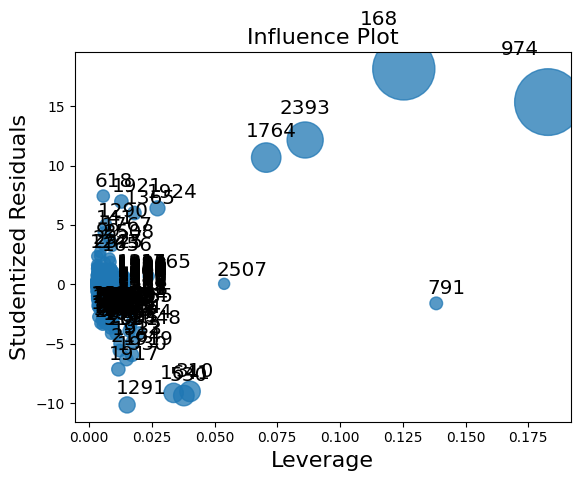

In [13]:
## Get the data and the dummy variables:
data = pd.merge(income[['Code', '2020', 'Voivodeship']], population[['Code', '2020']], on='Code', suffixes=['income', 'population'])
data.dropna(inplace=True)
# Remove Warsaw
data = data.drop(index=1293)
data = pd.get_dummies(data, columns=['Voivodeship'])
Y = data['2020income']

## Fit a model that encodes each voivodeship with a dummy variable:
X = data.iloc[:, 2:]
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

# Results of RESET test
print(sm.stats.diagnostic.linear_reset(results, power=3, test_type='fitted'))
# p-value = 0.0 -- we reject the null hypothesis -- the functional form is incorrect

## Get the fitted values:
fitted_values_summary = results.get_prediction().summary_frame()
fitted_values = fitted_values_summary['mean']
## Compute the residuals:
residuals = Y - fitted_values

## The average prediction error can be estimated by RMSE
## (it's an estimation on training data, so it's biased)
print('RMSE of the model:', np.sqrt(np.mean(residuals**2)))
## Standardize the residuals & compute the square root:
residuals_standardized = (residuals - residuals.mean())/residuals.std()
residuals_sqroot = np.sqrt(np.abs(residuals_standardized))
## Diagnostic plots:
px.scatter(x=fitted_values, y=residuals,
           title='Residual vs fitted value').add_scatter(x=[min(fitted_values),
                                                            max(fitted_values)],
                                                         y=[0,0]).show()
px.scatter(x=fitted_values, y=residuals_sqroot, title='Scale vs location').show()
px.histogram(x=residuals, title='Residuals').show()
sm.graphics.influence_plot(results, criterion="cooks").show()

Let's now check if transforming the data will help:

                            OLS Regression Results                            
Dep. Variable:             2020income   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     1473.
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:55:54   Log-Likelihood:                 1472.0
No. Observations:                2476   AIC:                            -2910.
Df Residuals:                    2459   BIC:                            -2811.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
2020popula

/tmp/ipykernel_7646/2265887129.py:43: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



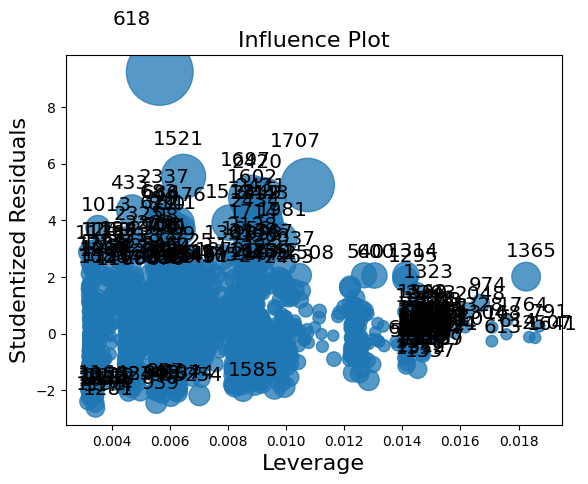

In [14]:
## Get the data and the dummy variables:
data = pd.merge(income[['Code', '2020', 'Voivodeship']], population[['Code', '2020']], on='Code', suffixes=['income', 'population'])
data.dropna(inplace=True)
# Remove Warsaw
data = data.drop(index=1293)
data = pd.get_dummies(data, columns=['Voivodeship'])
Y = data['2020income']
# transform Y
Y = np.log10(Y)

## Fit a model that encodes each voivodeship with a dummy variable:
X = data.iloc[:, 2:]
# transform X
X['2020population'] = np.log10(X['2020population'])
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

# Results of RESET test
print(sm.stats.diagnostic.linear_reset(results, power=3, test_type='fitted'))

## Get the fitted values:
fitted_values_summary = results.get_prediction().summary_frame()
fitted_values = fitted_values_summary['mean']
## Compute the residuals:
residuals = Y - fitted_values

## The average prediction error can be estimated by RMSE
## (it's an estimation on training data, so it's biased)
print('RMSE of the model:', np.sqrt(np.mean(residuals**2)))
# for log-transformed data, we need to transform the predictions back:
print('RMSE of back-transformed model:', np.sqrt(np.mean((10**Y - 10**fitted_values)**2)))
## Standardize the residuals & compute the square root:
residuals_standardized = (residuals - residuals.mean())/residuals.std()
residuals_sqroot = np.sqrt(np.abs(residuals_standardized))
## Diagnostic plots:
px.scatter(x=fitted_values, y=residuals,
           title='Residual vs fitted value').add_scatter(x=[min(fitted_values),
                                                            max(fitted_values)],
                                                         y=[0,0]).show()
px.scatter(x=fitted_values, y=residuals_sqroot, title='Scale vs location').show()
px.histogram(x=residuals, title='Residuals').show()
sm.graphics.influence_plot(results, criterion="cooks").show()

## Linear regression and SVD

The estimator of $\beta$ is given by the equation
$$\hat{\beta} = (X^TX)^{-1}X^TY.$$
From a computational point of view, using this equation is inefficient and can lead to numerical errors.  
A more efficient approach is based on the [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) of the $X$ matrix, given by $X = U\Sigma V^T$.  
We have already used the SVD decomposition to implement the Principal Component Analysis in one of the previous notebooks.   

**Exercise 3.** In this exercise, we will implement a linear regression method using the SVD decomposition and create a linear regression model to predict the income of a municipality in 2020 based on its population and voivodeship. Use the SVD decomposition of $X$ to obtain a more efficient formula for $\hat{\beta}$.  

Implement a function that takes an numpy vector of dependent variables `Y` and a numpy array of independent variables `X` and, using the SVD decomposition, computes and returns the estimated regression parameters.

Compare the results of your implementation with the one from `statsmodels`. You can find the relevant documentation [here](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html).  


In [15]:
## Implement the function:
def my_regression(X, Y):
  """
  Return the estimation of the regression parameters for Y ~ X\beta + \epsilon.
  X is the data matrix.
  """
  U, S, Vt = svd(X)
  beta = np.dot(U.T, Y)
  beta = beta[:len(S)]/S
  beta = np.dot(beta, Vt)
  return beta
